In [1]:
import os
os.environ["WANDB_API_KEY"] = "dcf9600e0485401cbb0ddbb0f7be1c70f96b32ef"
os.environ["WANDB_MODE"] = "disabled"
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipdb
import wandb
from sigma_layer_vgg import SigmaModel_SimpleCNN
from utils import get_dataset, compute_SCL_loss, gradient_centralization
import datetime

import logging
logging.basicConfig(level=logging.INFO)
logging.basicConfig(level=logging.INFO)  # Set the logging level to INFO
logger = logging.getLogger(__name__)  # Create a logger instance for your module
info = logger.info  # Shorthand for logger.info


# Parse arguments
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# Training scheme group
method_parser = parser.add_argument_group("Method")
method_parser.add_argument('--method', type=str, default='SIGMA', choices=['SIGMA', 'BP', 'FA'])
method_parser.add_argument('--architecture', type=str, default='vgg', choices=['lenet', 'vgg'])
method_parser.add_argument('--actfunc', type=str, default='elu', choices=['tanh', 'elu', 'relu'])
# Dataset group
dataset_parser = parser.add_argument_group('Dataset')
dataset_parser.add_argument('--dataset', type=str, default='CIFAR10', choices=['MNIST', 'CIFAR10'])
dataset_parser.add_argument('--batchsize', type=int, default=128)
# Training group # LR, optimizer, weight_decay, momentum
training_parser = parser.add_argument_group('Training')
training_parser.add_argument('--epochs', type=int, default=100)
training_parser.add_argument('--lr_bp', type=float, default=0.03)
training_parser.add_argument('--lr_F', type=float, default=0.2)
training_parser.add_argument('--lr_B', type=float, default=1)
training_parser.add_argument('--wd_F', type=float, default=0.0001)
training_parser.add_argument('--wd_B', type=float, default=0.0001)
training_parser.add_argument('--Fiter', type=int, default=0)
training_parser.add_argument('--Biter', type=int, default=0)
training_parser.add_argument('--optimizer', type=str, default='SGD', choices=['RMSprop', 'Adam', 'SGD'])
training_parser.add_argument('--GradC', type=int, default=0)
# Seed group
seed_parser = parser.add_argument_group('Seed')
seed_parser.add_argument('--seed', type=int, default=2023)
args, _ = parser.parse_known_args()

info("Parsed Arguments:")
for arg in vars(args):
    info(f"  {arg}: {getattr(args, arg)}")

# Set run_name
if args.method == "SIGMA":
    run_name = f"{args.dataset}_{args.method}_vgg_act{args.actfunc}_{args.optimizer}_F{args.lr_F}B{args.lr_B}_{args.seed}"
elif args.method == "BP":
    run_name = f"{args.dataset}_{args.method}_vgg_act{args.actfunc}_{args.optimizer}_{args.lr_bp}_{args.seed}"
time_stamp = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")

# Set wandb
wandb.init(
    project="opt-sigma",
    name=run_name,
    # track hyperparameters and run metadata
    config={
    "algorithm": args.method,
    "architecture": "VGG",
    "dataset": args.dataset,
    "epochs": args.epochs,
    "lr1": args.lr_bp if args.method == "BP" else args.lr_F,
    "lr2": args.lr_B if args.method == "SIGMA" else 0,
    "optimizer": args.optimizer,
    "seed": args.seed,
    "actfunc": args.actfunc,
    }
)

info(f"Run name: {run_name}")

# Set seed
torch.manual_seed(args.seed), np.random.seed(args.seed), torch.cuda.manual_seed(args.seed)

# Set device
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
info(f"Device: {device}")

# Get dataset
info(f"\n Loading {args.dataset} dataset")
train_loader, val_loader, test_loader = get_dataset(args)

class SigmaLoss(nn.Module):
    def __init__(self, args):
        super(SigmaLoss, self).__init__()
        self.args = args
        self.final_criteria = nn.CrossEntropyLoss()
        self.local_criteria = compute_SCL_loss
        self.method = args.method

        self.max_pool = nn.MaxPool2d(2, 2)

        self.max_pool = nn.AvgPool2d(2, 2)
        
    def forward(self, activations, signals, target, method="final"):
        if method == "local":
            loss = list()
            for idx, (act, sig) in enumerate(zip(activations[:-1], signals[:-1])):
                if len(act.shape) == 4 and len(sig.shape) == 2: sig = sig.view(sig.shape[0], sig.shape[1], act.shape[2], act.shape[3]) 
                if len(act.shape) == 2 and len(sig.shape) == 4: act = act.view(act.shape[0], act.shape[1], sig.shape[2], sig.shape[3])
                loss += [self.local_criteria(act, sig, target)]
            loss += [self.final_criteria(activations[-1], target)]
            return sum(loss), loss[-1].item()
        elif method == "final":
            loss = self.final_criteria(activations[-1], target)
            return loss, loss.item()
        
def normalize_along_axis(x):
    x = x.reshape(len(x), -1)
    norm = torch.norm(x, dim=1, keepdim=True)
    return x / (norm + 1e-8)
        
def compute_SCL_loss(A, B, target, error_mask=None):
    if error_mask is not None:
        A = A[error_mask]
        target = target[error_mask]
    A_norm, B_norm = normalize_along_axis(A), normalize_along_axis(B)
    C = A_norm@B_norm.T
    if len(B) == 10:
        target_A = F.one_hot(target, num_classes=10).float().to(target.device)
        target_B = F.one_hot(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long(), num_classes=10).float().to(target.device)
        identity = target_A@target_B.T
    else:
        target_A = F.one_hot(target, num_classes=10).float().to(target.device)
        identity = target_A@target_A.T

    D = A_norm@A_norm.T
    identity_D = torch.eye(A.shape[0]).to(A.device)

    E = B_norm@B_norm.T
    identity_E = torch.eye(B.shape[0]).to(B.device)

    return F.mse_loss(C, identity) + F.mse_loss(D, identity_D) * 0.5 + F.mse_loss(E, identity_E) * 0.5
        
model = SigmaModel_SimpleCNN(args)
model.to(device)
if args.optimizer == "SGD" and args.method == "BP": 
    forward_optimizer = optim.SGD(model.forward_params, lr=args.lr_bp, momentum=0.9, weight_decay=0.0001)
    forward_scheduler = CosineAnnealingLR(forward_optimizer, T_max=args.epochs, eta_min=1e-5)
elif args.optimizer == "SGD" and args.method == "SIGMA":
    forward_optimizer = optim.SGD(model.forward_params, lr=args.lr_F, momentum=0.9, weight_decay=args.wd_F)
    forward_scheduler = CosineAnnealingLR(forward_optimizer, T_max=args.epochs, eta_min=1e-5)
    backward_optimizer = optim.SGD(model.backward_params, lr=args.lr_B, momentum=0.9, weight_decay=args.wd_B)
    backward_scheduler = CosineAnnealingLR(backward_optimizer, T_max=args.epochs, eta_min=1e-5)
criteria = SigmaLoss(args)
    
with torch.no_grad():
    signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), return_activations=True)

best_val_loss = float('inf')
info(f"\n  Start training for {args.epochs} epochs")
for epoch in range(args.epochs):
    model.train()
    train_loss, train_counter = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.method == "SIGMA":
            activations = model(data.to(device), detach_grad=True)
            signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), detach_grad=True)
            loss, loss_item = criteria(activations, signals, target.to(device), method="local")
            if epoch == 0 and batch_idx < 100: loss *= (batch_idx+1) / 100
            # if epoch == 0 and batch_idx < 300: loss *= (batch_idx+1) / 300
            forward_optimizer.zero_grad(), backward_optimizer.zero_grad(), loss.backward()
            gradient_centralization(model)
            forward_optimizer.step(), backward_optimizer.step()
            train_loss += loss_item * len(data)
            train_counter += len(data)
        elif args.method == "BP":
            activations = model(data.to(device), detach_grad=False)
            loss, loss_item = criteria(activations, signals, target.to(device), method="final")
            forward_optimizer.zero_grad(), loss.backward(), forward_optimizer.step()
            train_loss += loss_item * len(data)
            train_counter += len(data)

    forward_scheduler.step()
    if args.method == "SIGMA": backward_scheduler.step()


    wandb.log({'train_loss': train_loss / train_counter}, step=epoch)
    # Log the norm of the first layer weights for both forward and backward layer
    wandb.log({'forward_layer_1_norm': torch.norm(model.conv1.forward_layer.weight).item()}, step=epoch)
    wandb.log({'backward_layer_1_norm': torch.norm(model.conv1.backward_layer.weight).item()}, step=epoch)
    wandb.log({'forward_layer_2_norm': torch.norm(model.conv2.forward_layer.weight).item()}, step=epoch)
    wandb.log({'backward_layer_2_norm': torch.norm(model.conv2.backward_layer.weight).item()}, step=epoch)
    wandb.log({'forward_layer_3_norm': torch.norm(model.conv3.forward_layer.weight).item()}, step=epoch)
    wandb.log({'backward_layer_3_norm': torch.norm(model.conv3.backward_layer.weight).item()}, step=epoch)
    wandb.log({'forward_layer_4_norm': torch.norm(model.conv4.forward_layer.weight).item()}, step=epoch)
    wandb.log({'backward_layer_4_norm': torch.norm(model.conv4.backward_layer.weight).item()}, step=epoch)

    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        activations = model(data.to(device), detach_grad=True)
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        loss *= loss * 0.1
        forward_optimizer.zero_grad(), loss.backward(), forward_optimizer.step()

    # Validation
    model.eval()
    val_correct, val_loss, val_counter = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            val_counter += len(data)
            if args.method == "SIGMA":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="local")
            elif args.method == "BP":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="final")
            prediction = activations[-1].detach()
            _, predicted = torch.max(prediction, 1)
            val_correct += (predicted == target.to(device)).sum().item()
            val_loss += loss_item * len(data)

    wandb.log({'val_loss': val_loss / val_counter, 
               'val_acc': val_correct / val_counter, 
               }, step=epoch)
    
    info(f"""Epoch {epoch} | train loss {train_loss / train_counter:.3f} | val loss {val_loss / val_counter:.3f} | val acc {100 * val_correct / val_counter:.2f}""")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), f'./saved_models/{run_name}-{time_stamp}.pt')
    
    # assert 0 == 1
    break
        
# Eval on Test Set by loading the best model 
model.load_state_dict(torch.load(f'./saved_models/{run_name}-{time_stamp}.pt'))
model.eval()
correct, total = 0, 0
test_loss, test_counter = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data.to(device), detach_grad=False)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == target.to(device)).sum().item()
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        test_loss += loss_item * len(data)
        test_counter += len(data)

wandb.log({'test_loss': test_loss / test_counter,
           'test_acc': 100 * correct / test_counter})

info(f'Epoch: {epoch}, Test Accuracy: {100 * correct / test_counter:.3f}%')

INFO:__main__:Parsed Arguments:
INFO:__main__:  method: SIGMA
INFO:__main__:  architecture: vgg
INFO:__main__:  actfunc: elu
INFO:__main__:  dataset: CIFAR10
INFO:__main__:  batchsize: 128
INFO:__main__:  epochs: 100
INFO:__main__:  lr_bp: 0.03
INFO:__main__:  lr_F: 0.2
INFO:__main__:  lr_B: 1
INFO:__main__:  wd_F: 0.0001
INFO:__main__:  wd_B: 0.0001
INFO:__main__:  Fiter: 0
INFO:__main__:  Biter: 0
INFO:__main__:  optimizer: SGD
INFO:__main__:  GradC: 0
INFO:__main__:  seed: 2023
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
INFO:__main__:Run name: CIFAR10_SIGMA_vgg_actelu_SGD_F0.2B1_2023
INFO:__main__:Device: cpu
INFO:__main__:
 Loading CIFAR10 dataset


Files already downloaded and verified
Files already downloaded and verified


INFO:__main__:
  Start training for 100 epochs
INFO:__main__:Epoch 0 | train loss 2.219 | val loss 1.943 | val acc 55.56


AttributeError: 'list' object has no attribute 'data'

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])

In [8]:
activations[-1].argmax(1)

tensor([7, 6, 8, 7, 7, 2, 5, 9, 6, 4, 0, 0, 0, 8, 1, 5])

cat
Predicted: horse


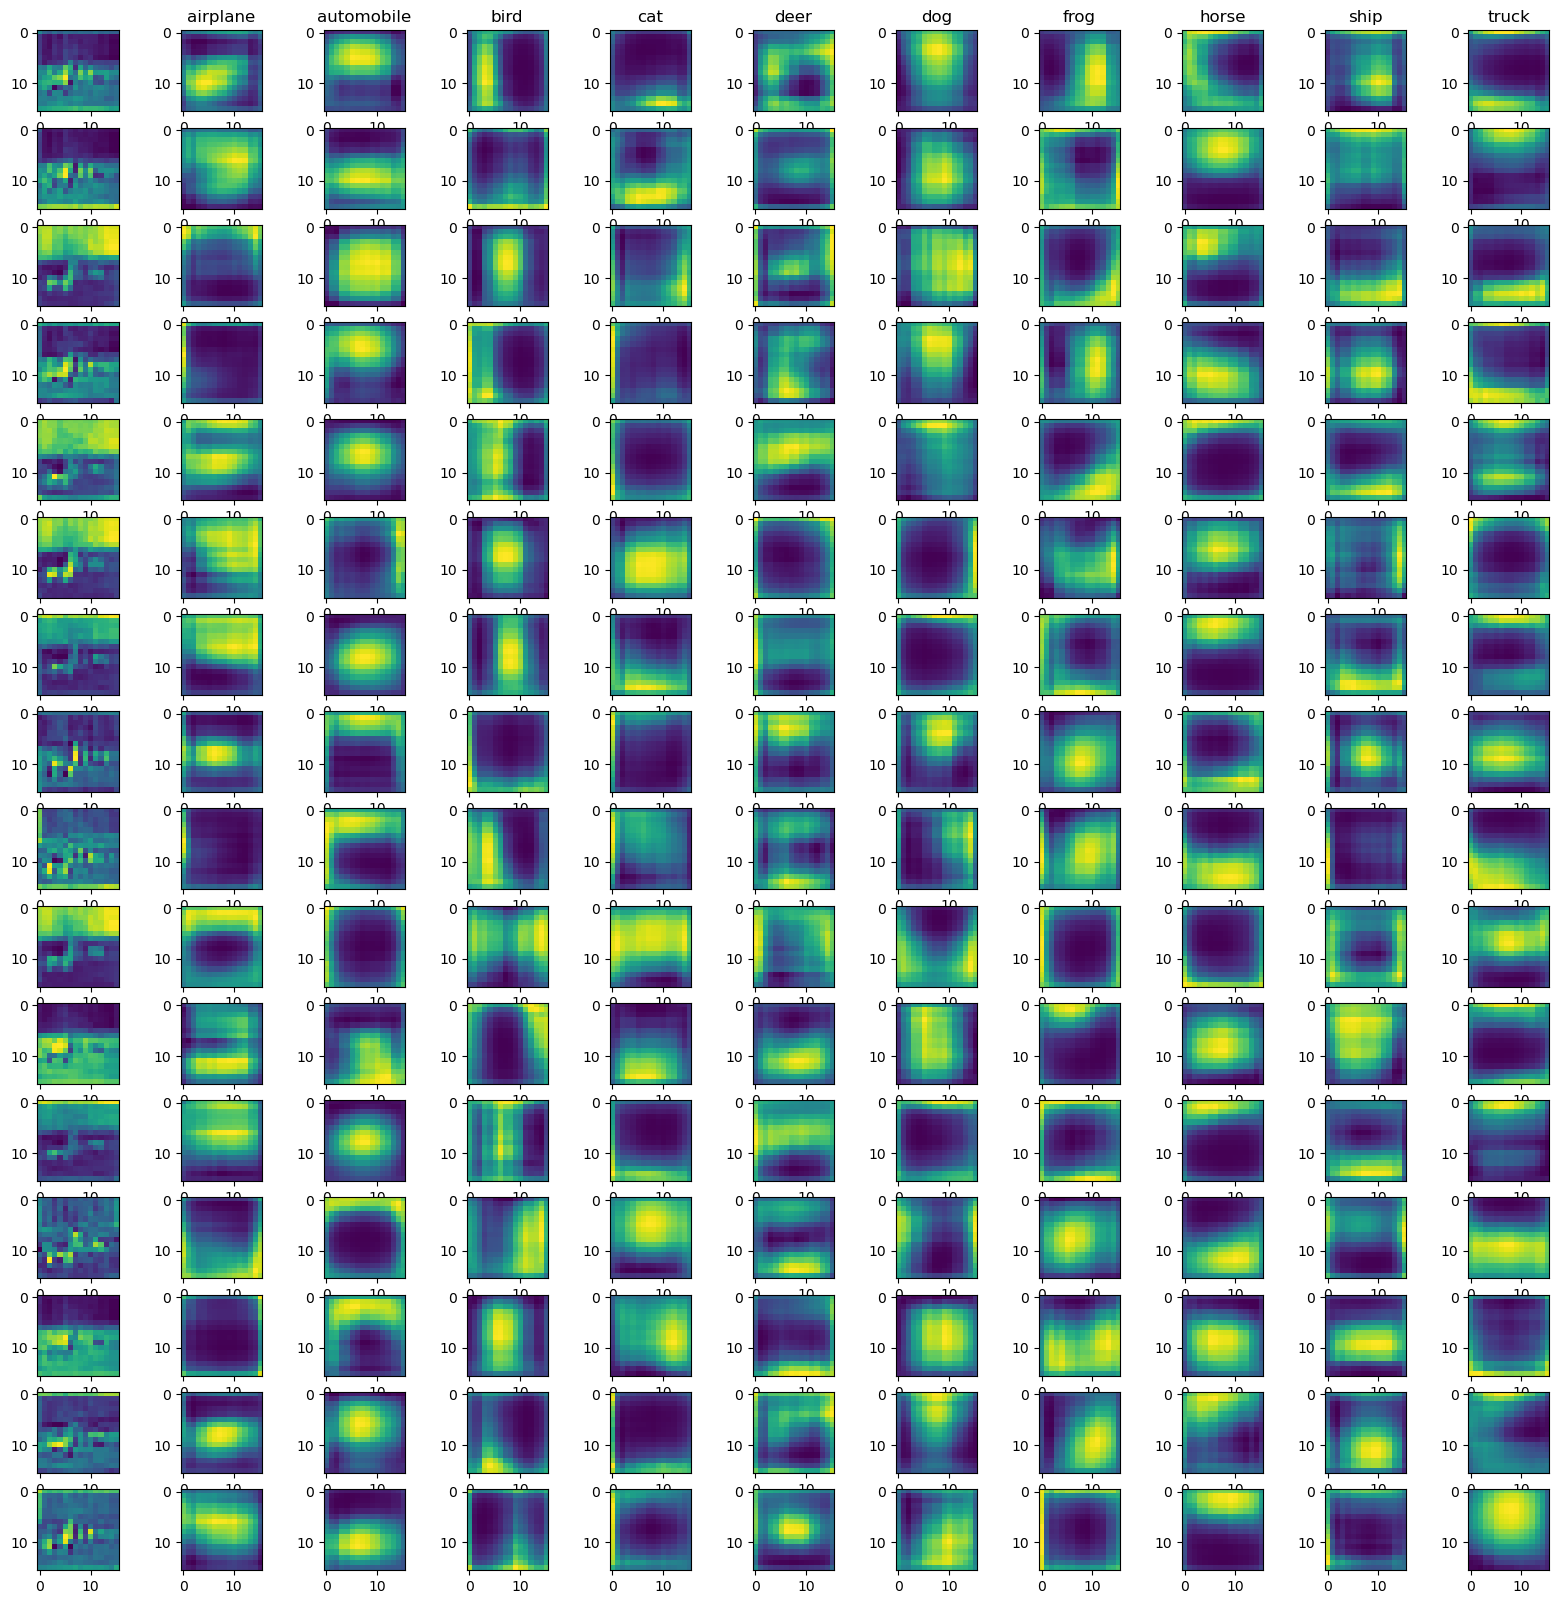

In [9]:
# Plot the activation function maps of signals[0]
# The output is a 10 * 11 subplot, where the rightmost column is the activation from the ten classes, and the first column is the activation of the input at the first layer.
# Each row is the activaion of different channels.

# add the cifar10 class name to the plot as title of the first row
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(class_names[target[0]])
print(f"Predicted: {class_names[predicted[0]]}")

act = activations[0].detach().cpu().numpy() # bs x 32 x 16 x 16, we only plot the first one
sig = signals[0].detach().cpu().numpy() # 10 x 32 x 16 x 16

fig, axes = plt.subplots(16, 11, figsize=(20, 20))
for i in range(16):
    axes[i, 0].imshow(act[0, i])
for i in range(10):
    for j in range(16):
        if j == 0: axes[j, i+1].set_title(class_names[i])
        axes[j, i+1].imshow(sig[i, j])
plt.pause(0.1)

cat
Predicted: horse


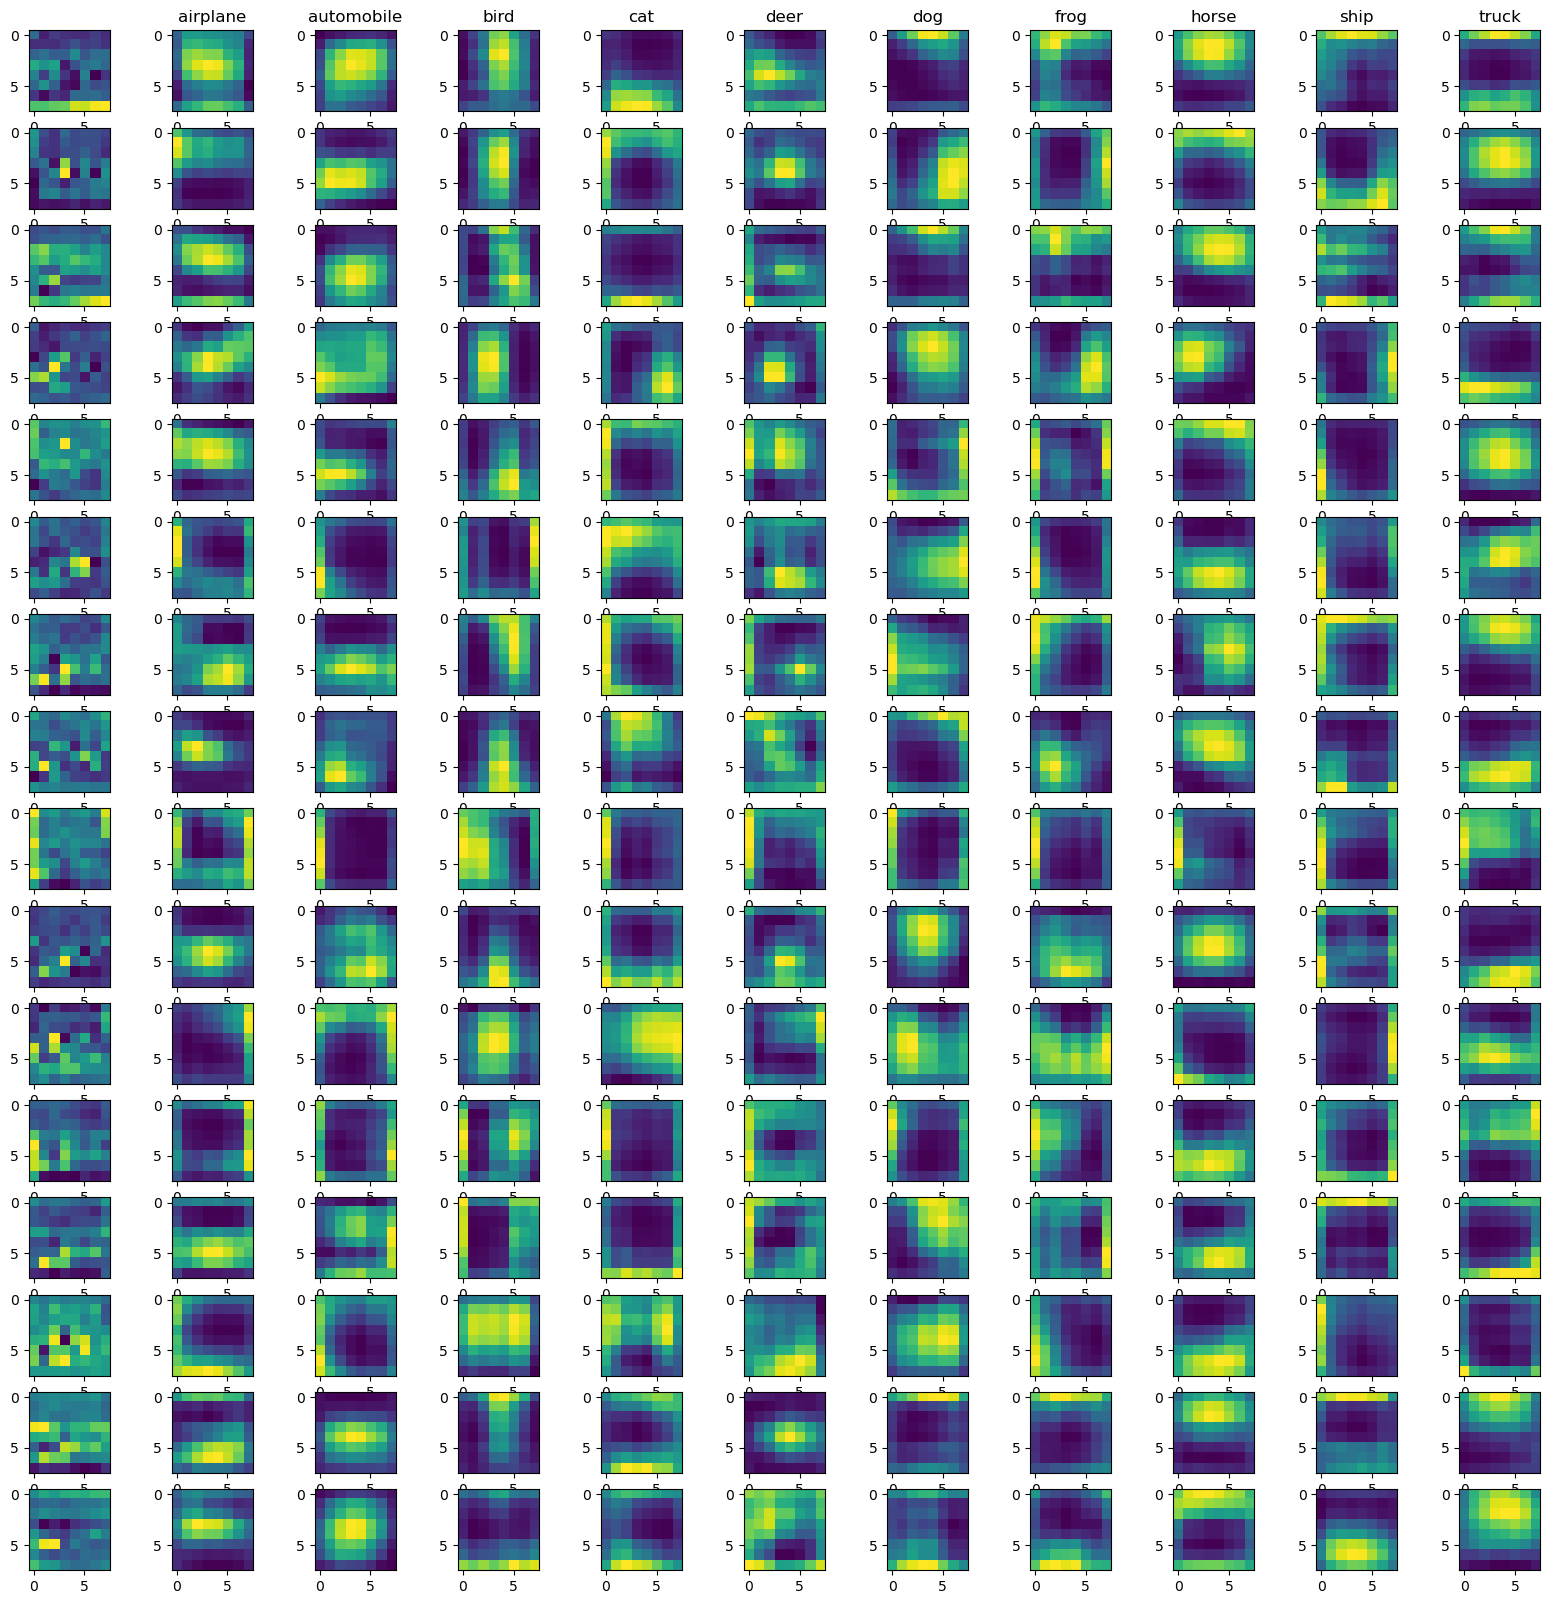

In [10]:
# Plot the activation function maps of signals[0]
# The output is a 10 * 11 subplot, where the rightmost column is the activation from the ten classes, and the first column is the activation of the input at the first layer.
# Each row is the activaion of different channels.

# add the cifar10 class name to the plot as title of the first row
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(class_names[target[0]])
print(f"Predicted: {class_names[predicted[0]]}")

act = activations[1].detach().cpu().numpy() # bs x 32 x 16 x 16, we only plot the first one
sig = signals[1].detach().cpu().numpy() # 10 x 32 x 16 x 16

fig, axes = plt.subplots(16, 11, figsize=(20, 20))
for i in range(16):
    axes[i, 0].imshow(act[0, i])
for i in range(10):
    for j in range(16):
        if j == 0: axes[j, i+1].set_title(class_names[i])
        axes[j, i+1].imshow(sig[i, j])
plt.pause(0.1)